# Edit the original df to create primary df (prior to data control and statistical analysis)
Read the original proteomics data, process it by:
renaming the missing symbols
changing column names (to make it easier to follow)
removing rows with all zeros

In [ ]:
%run scripts/edit_data/edit.py

# Post statistical analysis to extract DE proteins

In [ ]:
%run scripts/post_statistical_analysis/process_PSA.py

# Enrichment analysis

## enquiry string  
- retrieve enriched terms
- retrieve enriched network 

In [ ]:
%run scripts/enrichment_analysis/string_enquiry.py

## plot enriched terms

In [ ]:
%run scripts/enrichment_analysis/plot_EA.py 

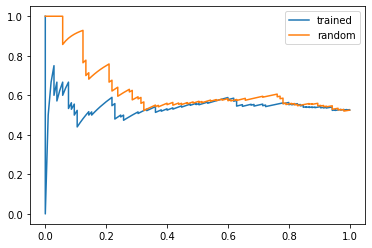

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_recall_curve

# generate some random data for classification
X = np.random.randn(1000, 10)
y = np.random.randint(2, size=1000)

# split the data into training and test sets
X_train, X_test = X[:800], X[800:]
y_train, y_test = y[:800], y[800:]

# train a logistic regression model on the training data
model = LogisticRegression()
model.fit(X_train, y_train)

# compute the recall and precision values for the test data using the trained model
y_scores = model.decision_function(X_test)
precision_trained, recall_trained, thresholds_trained = precision_recall_curve(y_test, y_scores)
trained_model_recall = recall_score(y_test, model.predict(X_test))

# compute the recall and precision values for the test data using a random model
random_scores = np.random.randn(len(y_test))
precision_random, recall_random, thresholds_random = precision_recall_curve(y_test, random_scores)
random_model_recall = recall_score(y_test, random_scores > 0)

def normalize(aa):
    return (aa-min(aa))/(max(aa)-min(aa))
# plt.plot(np.linspace(0, 1, len(recall_trained)), recall_trained, label='trained')
# plt.plot(np.linspace(0, 1, len(recall_random)), recall_random, label='random')
# plt.plot(normalize(thresholds_trained), recall_trained[:-1], label=f'trained:{np.mean(recall_trained[:-1])}')
# plt.plot(normalize(thresholds_random), recall_random[:-1], label=f'random:{np.mean(recall_random[:-1])}')
plt.plot(recall_trained, precision_trained, label='trained')
plt.plot(recall_random, precision_random, label='random')
plt.legend()

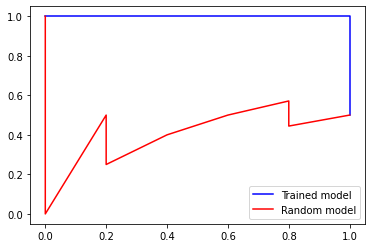

In [181]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
# np.random.seed(123)

# Generate some random data
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01)

# Train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(X_train, y_train)

# Get the predicted probabilities for the test set
y_proba = clf.predict_proba(X_test)[:, 1]

# Compute the precision-recall curve for the trained model
precision_trained, recall_trained, thresholds_trained = precision_recall_curve(y_test, y_proba)

# Create a random model that predicts a uniform distribution of probabilities
y_random = np.random.uniform(size=len(y_test))

# Compute the precision-recall curve for the random model
precision_random, recall_random, thresholds_random = precision_recall_curve(y_test, y_random)

# Plot the precision-recall curves for both models
plt.plot(recall_trained, precision_trained, color='b', label='Trained model')
plt.plot(recall_random, precision_random, color='r', label='Random model')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.legend()
# plt.show()
# plt.plot(normalize(thresholds_trained), recall_trained[:-1], label=f'trained:{np.mean(recall_trained[:-1])}')
# plt.plot(normalize(thresholds_random), recall_random[:-1], label=f'random:{np.mean(recall_random[:-1])}')
plt.legend()


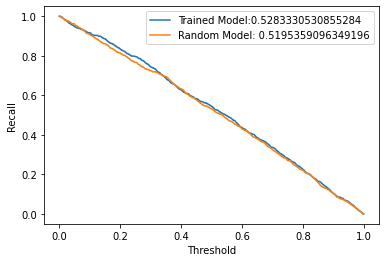

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve

# Generate a toy dataset
np.random.seed(42)
X = np.random.normal(0, 1, size=(1000, 5))
y = np.random.randint(2, size=1000)

# Train a logistic regression model
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(X, y)

# Get predicted probabilities for the trained model
y_trained = clf.predict_proba(X)[:, 1]

# Generate predicted probabilities for a random model
y_random = np.random.uniform(0, 1, size=1000)

# Calculate precision, recall and thresholds for the trained and random models
precision_trained, recall_trained, thresholds_trained = precision_recall_curve(y, y_trained)
precision_random, recall_random, thresholds_random = precision_recall_curve(y, y_random)

# Plot recall-threshold curves for the trained and random models
plt.plot(np.linspace(0,1, len(recall_trained)), recall_trained, label=f'Trained Model:{np.mean(recall_trained)}')
plt.plot(np.linspace(0,1, len(recall_random)), recall_random, label=f'Random Model: {np.mean(recall_random)}')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.legend()
plt.show()


# Noncategorized 

In [ ]:
# plot the time series of sig prots
utils.plot_time_series(df, prots=sig_prots, c_tag='ctr_', s_tag='mg_', p_ID='Entry', time=specs['time'], ee=0.5)

In [ ]:
# visualize the sig proteins for original and imputed versions
from scripts import utils
candids = sig_prots[0:10]
utils.plot_time_series_mutual(df1=df,df2=df_imput, prots=candids, )

plot time serties of Moreneo's sig prots and check which ones are detected in our analysis

In [ ]:
from scripts import utils
importlib.reload(utils)
moreneo_sigs = ['SDF4','NUFIP2','BUB3','HMGA2','KIF5B','DYNC1I2','DCTN1','S100A10','SYNPO2','MARCKS','THY1','HUWE1','PRPF8','RPS18','GCN1L1','RPL14','RBM8A','RPL23A','CANX','DLST','PDHB','ALDOC','APOA1','GGH','UAP1','ENO2','BAG3','HNRNPAB','BASP1','THRAP3','LRPPRC','CSE1L','PABPC4']
utils.plot_time_series(df, prots=moreneo_sigs[0:len(moreneo_sigs)], c_tag='ctr_', s_tag='mg_', p_ID='Gene', time=specs['time'], ee=0.5)

In [ ]:
# check the overlap between Moreneo's sig prots and this study
df_overlap = df_sig.loc[df_sig['Gene'].isin(moreneo_sigs)]
prots_overlap = df_overlap['Entry'].values
print(prots_overlap)
# utils.plot_time_series(df, prots=prots_overlap, c_tag='ctr_', s_tag='mg_', p_ID='Gene', time=specs['time'], ee=0.5)
# print(prots_overlap)
df_sig.head()

In [ ]:
# imputing code
import copy
def KNNImputer(df, n_neighbors=2): #TODO: n neighbors should be evaluated
    from sklearn import impute
    df_copy = copy.deepcopy(df)
    data = df[[f'ctr_{i}' for i in time]+[f'mg_{i}' for i in time]].values
    imputer = impute.KNNImputer(n_neighbors=n_neighbors)
    new_data = imputer.fit_transform(data)
    df_copy[[f'ctr_{i}' for i in time]+[f'mg_{i}' for i in time]] = new_data
    return df_copy
df_imput = KNNImputer(df) #TODO: this can be experimented
for gene in df_imput['Entry'].values:
    if df_imput.loc[df_imput['Entry']==gene].isna().values.any():
        print('still missing values: ', gene)

# Standalone codes

## Plot p values for showcase

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
def comic_font():
    matplotlib.rc('font', family='Comic Sans MS')
    matplotlib.rc('text', usetex='false')
    matplotlib.rcParams.update({'font.size': 22})
comic_font()

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = stats.norm.pdf(x, mu, sigma)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(x, y, color='cyan', linewidth=4)
# ax.set_xticks([])
# ax.set_xticklabels([])
# ax.set_yticks([])
# ax.set_yticklabels([])
ax.axis('off')
x_critical = 1.8

xx1 = np.linspace(x_critical, mu + 3*sigma, 100)
xx2 = np.linspace(mu - 3*sigma, -x_critical, 100)
ax.fill_between(xx1, 0, stats.norm.pdf(xx1, mu, sigma), color='r')
ax.fill_between(xx2, 0, stats.norm.pdf(xx2, mu, sigma), color='r')

ax.annotate('Critical value', xy=(x_critical, 0), xytext=(x_critical-1.7, .05),
                        arrowprops={'arrowstyle': '->'}, horizontalalignment='center')
ax.annotate('', xy=(-x_critical, 0), xytext=(x_critical-2.5, .03),
                        arrowprops={'arrowstyle': '->'}
                        , horizontalalignment='center')
fig.savefig('C:/Users/nourisa/My Drive/professional/manuscripts/MSC_Mg_omics/draw/show_sig.png', dpi=200)
plt.show()

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.datasets import make_regression

# Generate a synthetic dataset with 20 samples
X, y = make_regression(n_samples=20, n_features=1, noise=100, random_state=3)

# Fit a Ridge Regression model with lambda=10
model = Ridge(alpha=10)
model.fit(X, y)
y_pred = model.predict(X)

# Plot the data points and the regression line for lambda=10
fig = plt.figure(frameon=True, figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.plot(X, y_pred, label='Fit', linewidth=4, c='black', alpha=.5)

# Plot vertical dashed lines from the fitted line with lambda=10 to each data point
for i in range(X.shape[0]):
    ax.plot([X[i,0], X[i,0]], [y[i], y_pred[i]], '--', color='green', alpha=0.5, linewidth=3 )

ax.scatter(X, y, s=60, label='Data', linewidth=2, c='red')
ax.legend(frameon=False, fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('')

ax.arrow(0, 0, 2, 0, head_width=0.05, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 0, 1, head_width=0.05, head_length=0.1, fc='k', ec='k')

# Remove the axis spines and labels
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
fig.savefig('ridge.png', dpi=200)

plt.show()


# String API